In [3]:
import numpy as np
from scipy import misc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0,20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [12]:
# get camera trajectory saved into result file
dirc = ""
file = open("CameraTrajectory.txt", "r")
one_line = file.readline()
result = []
while (one_line != ''):
    num = one_line.split(' ')
    one_result = [float(num[0]), float(num[1]), float(num[2]), float(num[3]),
                  float(num[4]), float(num[5]), float(num[6]), float(num[7])]
    result.append(one_result)
    one_line = file.readline()    
result = np.array(result)
file.close()
# get association file
file = open("associations.txt", "r")
one_line = file.readline()
association = []
while (one_line != ''):
    num = one_line.split(' ')
    one_result = [float(num[0]), num[1], float(num[2]), num[3][8:-1]] # remove aligh keyword
    association.append(one_result)
    one_line = file.readline() 
association = np.array(association)
file.close()

# open a file to write the dense map result
num_images = result.shape[0]
scale_factor = 5000.0;
fx = 613.494812;
fy = 613.494873;
cx = 251.7;
cy = 305.02;

dense_static_map = None
for i in range(num_images):
    # find associated rbg and depth image 
    print i # print one value to check the code is running
    timestamp = result[i,0]
    assoc_timestamps = (association[:,0]).astype(float)
    assoc_row = np.where(abs(assoc_timestamps - timestamp) < 0.01)[0][0] # find the first one and smaller error
    rgb_file = association[assoc_row, 1]
    depth_file = association[assoc_row, 3]
    
    # load image
    img_rgb = misc.imread('rgb/'+rgb_file)
    img_dep = misc.imread('depth/'+depth_file)
    num_rows, num_cols = img_rgb.shape[0], img_rgb.shape[1]
    
    # convert quaternion to rotation and translation
    qx = result[i,4]
    qy = result[i,5]
    qz = result[i,6]
    qw = result[i,7]
    rot_matrix = np.array([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
                           [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
                           [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]])
    tran_vec = result[i,1:4]
    
    # get orig point
    z_values = img_dep / scale_factor;
    z_values = np.reshape(z_values, (1,num_rows*num_cols))[0]
    # print z_values
    x_values = np.array(list(xrange(num_cols))*num_rows) + 1  # start at 0
    x_values = (x_values - cx) * z_values / fx
    # print x_values
    y_values = np.repeat(xrange(num_rows), num_cols) + 1 # start at 0
    y_values = (y_values - cy) * z_values / fy
    # print y_values
    orig_points = np.array([x_values, y_values, z_values])
    trans_points = rot_matrix.dot(orig_points) + np.repeat([tran_vec], orig_points.shape[1], axis=0).T
    
    # all all transformation that depth is not zero
    valid_cols = list(np.where(orig_points[2,:] != 0)[0])
    trans_points_valid = trans_points[:, valid_cols]
    # get rgb point
    rgb_matrix = img_rgb.T
    rgb_matrix = rgb_matrix.transpose((0, 2, 1))
    rgb_matrix = np.reshape(rgb_matrix, (3, num_rows*num_cols))
    rgb_matrix_valid = rgb_matrix[:,valid_cols]
    write_matrix = np.concatenate((trans_points_valid, rgb_matrix_valid), axis=0).T
    if i == 0:
        dense_static_map = write_matrix
    else:
        dense_static_map = np.concatenate((dense_static_map, write_matrix), axis=0)
    # print dense_static_map.shape
    
# plot the dense make

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


In [13]:
print dense_static_map.shape

(41109673, 6)


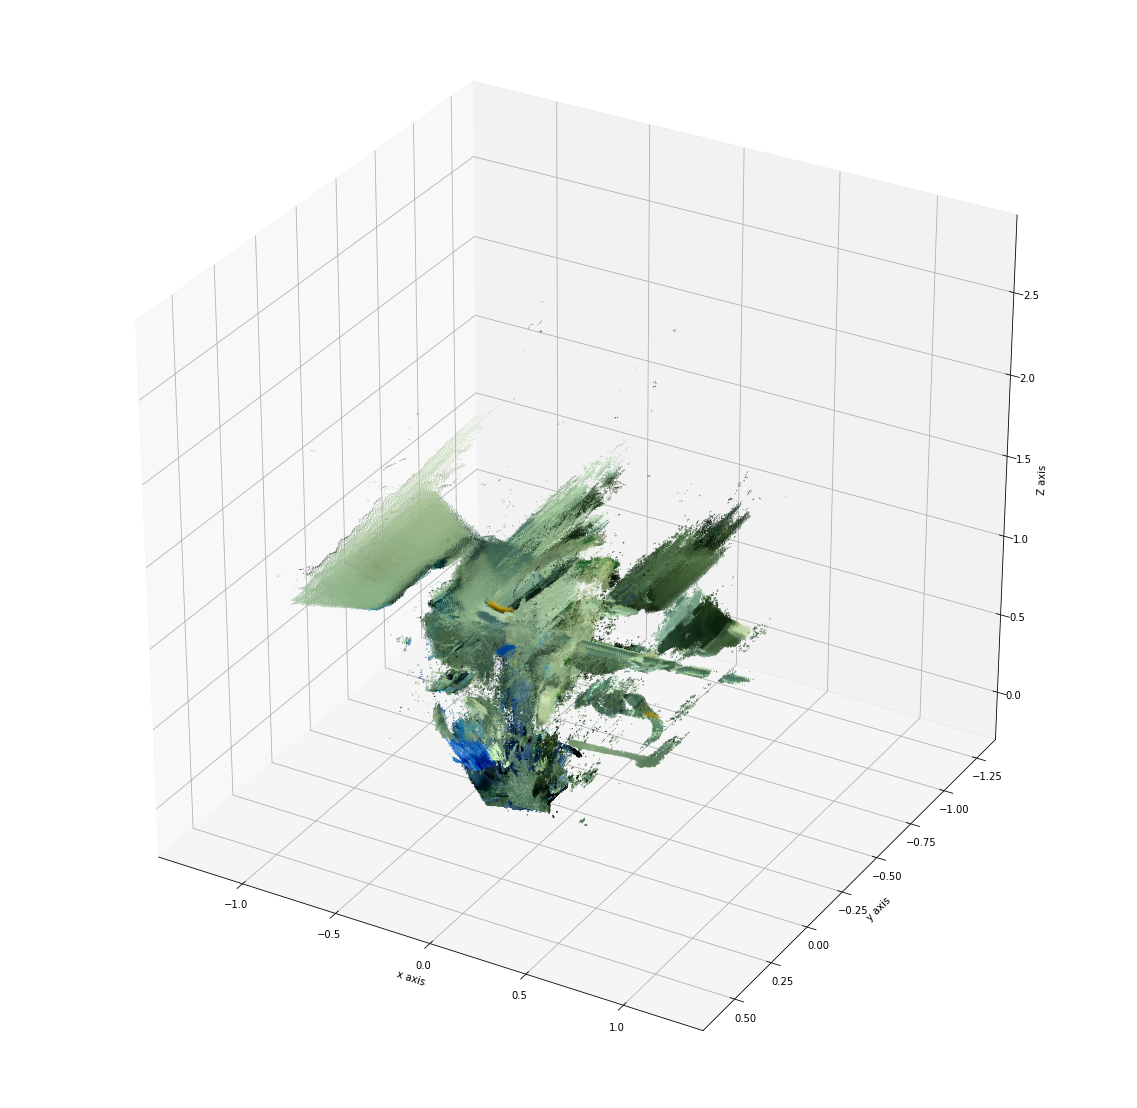

In [15]:
total_num = dense_static_map.shape[0]
index = np.arange(0,total_num,5) 
x = dense_static_map[index,0]
y = dense_static_map[index,1]
z = dense_static_map[index,2]
rgb = dense_static_map[index,3:6]/256

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=1, facecolors=rgb, marker='o', lw = 0)
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('Z axis')
ax.invert_yaxis()
plt.show()

In [14]:
np.save('dense_static_map.npy', dense_static_map)

In [ ]:
dense_static_map = np.load("dense_static_map.npy")